*Pirmas Laboratorinis darbas*

Studentas: **Karolis Miežetis**

Reikalavimai realizuoti:

1. efektyvią duomenų nuskaitymo programą su pasirinku egzistuojančiu iš anksto apmokytu (angl. pre-trained) vaizdų klasifikavimo modeliu,
2. paskaičiuoti tikslumo, precizijos, atkūrimo ir F1 statistikas pasirinktiems 1000 paveikslėlių iš OpenImages,
3. realizuoti slenkstinės reikšmės (angl. threshold) keitimą, įgalinant klasifikuoti vaizdus kiekvienai užduotai klasei keičiant threshold.
Statistikos turi persiskaičiuoti po slenkstinės reikšmės pakeitimo.

Pasirinktos klasės:
**Bread, Cat, Banana**

Pasirinkta Architektūra:
Resnet50 su ResNet50_Weights.IMAGENET1K_V2 - neuroninis tinklas su 50 sluoksnių, geba klasifikuoti nuotraukas į 1000 skirtingų klasių.

In [ ]:
pip install openimages torchvision

In [ ]:
import os
import torch
import torchvision
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image, ImageOps
from openimages.download import download_dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = "data"
number_of_samples = 340
classes = ["Bread", "Cat", "Banana"]
threshold = 0.5
temperature = 1.5

In [ ]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
from openimages.download import download_dataset
print("Downloading dataset...")
download_dataset(data_dir, classes, limit=number_of_samples)

100%|██████████| 340/340 [00:09<00:00, 36.65it/s]


{'bread': {'images_dir': 'data/bread/images'},
 'cat': {'images_dir': 'data/cat/images'},
 'banana': {'images_dir': 'data/banana/images'}}

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=0.02, saturation=0.02),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, prefetch_factor=2)

In [ ]:
classes = sorted(dataset.classes)

In [ ]:
# Pakraunu istreniruota ResNet50 modeli
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
print("\nTraining Last Layer...")
model.train()
for epoch in range(5):
    total_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader):.4f}")


Training Last Layer...
Epoch 1, Loss: 0.0605
Epoch 2, Loss: 0.0618
Epoch 3, Loss: 0.0381
Epoch 4, Loss: 0.0539
Epoch 5, Loss: 0.0389


In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def custom_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    images, labels = zip(*batch)
    return torch.stack(images), torch.tensor(labels)

In [ ]:
dataset = CustomDataset(data_dir)
print(f"Total dataset size: {len(dataset)} images")

Dataset loaded. Total images: 1020
Total dataset size: 1020 images


In [ ]:
def evaluate_with_graphs(model, loader, thresholds=[0.1, 0.3, 0.5, 0.7, 0.8]):
    acc_list, prec_list, rec_list, f1_list = [], [], [], []

    for threshold in thresholds:
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for batch in loader:
                if batch is None:
                    continue

                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                outputs = torch.nn.functional.softmax(model(images) / 1.0, dim=1)
                max_probs, pred_classes = outputs.max(dim=1)

                preds = torch.where(max_probs > threshold, pred_classes, torch.tensor(-1, device=labels.device))

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(max_probs.cpu().numpy())

        valid_indices = np.array(all_preds) != -1
        valid_preds = np.array(all_preds)[valid_indices]
        valid_labels = np.array(all_labels)[valid_indices]

        if len(valid_preds) == 0 or len(valid_labels) == 0:
            print(f"No valid predictions at threshold {threshold}.")
            acc, prec, rec, f1 = 0, 0, 0, 0
        else:
            acc = accuracy_score(valid_labels, valid_preds)
            prec = precision_score(valid_labels, valid_preds, average='macro', zero_division=1)
            rec = recall_score(valid_labels, valid_preds, average='macro', zero_division=1)
            f1 = f1_score(valid_labels, valid_preds, average='macro')

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)

        print(f"Threshold {threshold:.1f} → Accuracy: {acc:.7f}, Precision: {prec:.7f}, Recall: {rec:.7f}, F1-score: {f1:.7f}")

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, acc_list, marker='o', label="Accuracy")
    plt.plot(thresholds, prec_list, marker='o', label="Precision")
    plt.plot(thresholds, rec_list, marker='o', label="Recall")
    plt.plot(thresholds, f1_list, marker='o', label="F1-score")

    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("Model Performance at Different Thresholds (Temperature Scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()

Threshold 0.1 → Accuracy: 0.9980392, Precision: 0.9980507, Recall: 0.9980392, F1-score: 0.9980392
Threshold 0.3 → Accuracy: 0.9980392, Precision: 0.9980507, Recall: 0.9980392, F1-score: 0.9980406
Threshold 0.5 → Accuracy: 0.9950932, Precision: 0.9951691, Recall: 0.9950865, F1-score: 0.9950978
Threshold 0.7 → Accuracy: 1.0000000, Precision: 1.0000000, Recall: 1.0000000, F1-score: 1.0000000


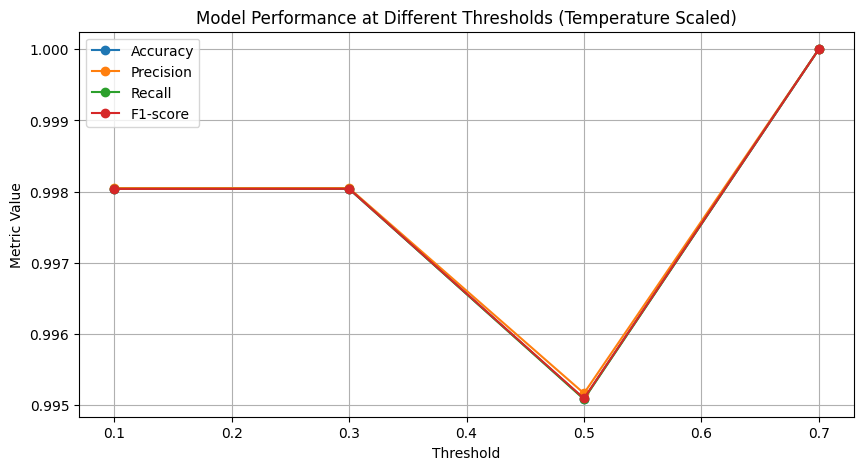

In [ ]:
evaluate_with_graphs(model, data_loader, thresholds=[0.1, 0.3, 0.5, 0.7])

In [ ]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()

    loader_list = list(loader)
    random_batch = random.choice(loader_list)

    if random_batch is None:
        print("No valid images to visualize.")
        return

    images, labels = random_batch
    images = images.to(device)

    with torch.no_grad():
        outputs = torch.nn.functional.softmax(model(images) / temperature, dim=1)
        preds = outputs.argmax(dim=1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(min(num_images, len(images))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {classes[preds[i].item()]}, True: {classes[labels[i].item()]}")
        axes[i].axis('off')

    plt.show()

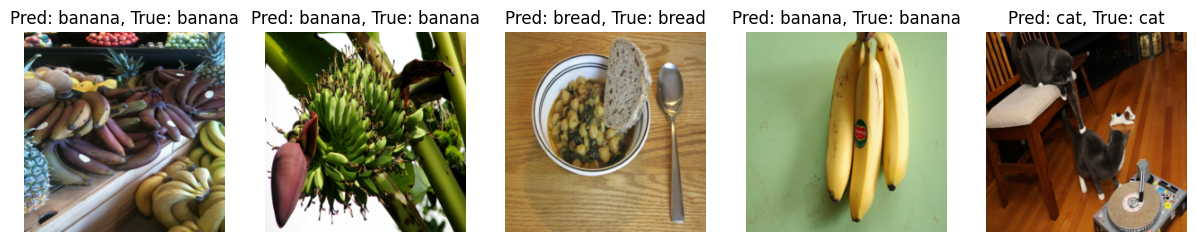

In [ ]:
# Run visualization
visualize_predictions(model, data_loader)

Upload test images...


Saving kato.jpg to kato.jpg
📸 Image: kato.jpg → Predicted: cat (Confidence: 0.66)


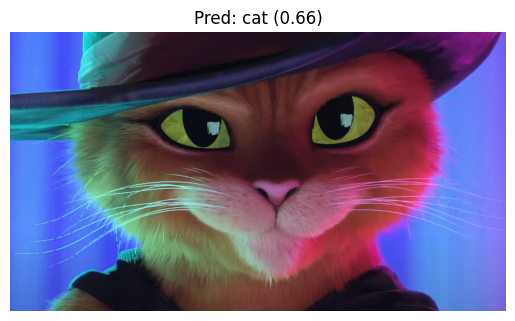

In [ ]:
from google.colab import files
import io
import PIL.Image

def classify_test_images(model, transform, temp=1.5):
    print("Upload test images...")

    uploaded_files = files.upload()

    if not uploaded_files:
        print("No images uploaded.")
        return

    test_images = []
    filenames = []

    for filename, file in uploaded_files.items():
        image = PIL.Image.open(io.BytesIO(file)).convert('RGB')
        image = ImageOps.exif_transpose(image)
        image = transform(image).unsqueeze(0)
        test_images.append(image)
        filenames.append(filename)

    test_images_tensor = torch.cat(test_images).to(device)

    model.eval()
    with torch.no_grad():
        outputs = torch.nn.functional.softmax(model(test_images_tensor) / temp, dim=1)
        max_probs, preds = outputs.max(dim=1)

    for i, filename in enumerate(filenames):
        pred_class = classes[preds[i].item()]
        confidence = max_probs[i].item()
        print(f"📸 Image: {filename} → Predicted: {pred_class} (Confidence: {confidence:.2f})")

        img = PIL.Image.open(io.BytesIO(uploaded_files[filename]))
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {pred_class} ({confidence:.2f})")
        plt.show()

classify_test_images(model, transform)
